Found 3001 images belonging to 8 classes.
Found 743 images belonging to 8 classes.
Epoch 1/25

Epoch 1: val_loss improved from inf to 2.38825, saving model to mobilenetv2_finetune_augmented.keras
47/47 - 67s - 1s/step - accuracy: 0.1539 - loss: 2.3640 - val_accuracy: 0.1884 - val_loss: 2.3882 - learning_rate: 1.0000e-05
Epoch 2/25

Epoch 2: val_loss improved from 2.38825 to 2.16710, saving model to mobilenetv2_finetune_augmented.keras
47/47 - 48s - 1s/step - accuracy: 0.2299 - loss: 2.0950 - val_accuracy: 0.2436 - val_loss: 2.1671 - learning_rate: 1.0000e-05
Epoch 3/25

Epoch 3: val_loss improved from 2.16710 to 1.98991, saving model to mobilenetv2_finetune_augmented.keras
47/47 - 83s - 2s/step - accuracy: 0.2982 - loss: 1.9061 - val_accuracy: 0.3001 - val_loss: 1.9899 - learning_rate: 1.0000e-05
Epoch 4/25

Epoch 4: val_loss improved from 1.98991 to 1.79566, saving model to mobilenetv2_finetune_augmented.keras
47/47 - 81s - 2s/step - accuracy: 0.3615 - loss: 1.7648 - val_accuracy: 0.3

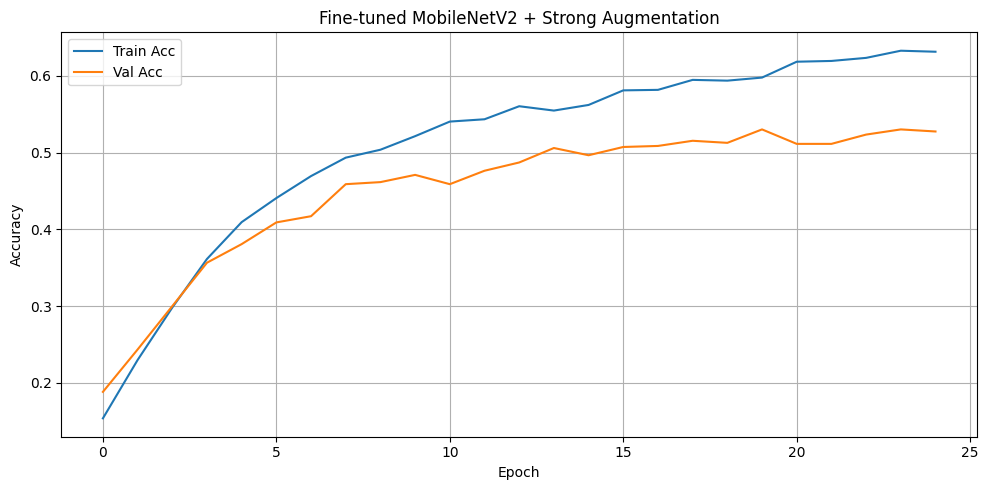

✅ Best val_acc: 0.5303 at epoch 20


In [2]:
# 📅 2025/06/06 - MobileNetV2 Fine-Tuning + Augmentation 강화 + 시각화 출력까지

import os
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# 데이터 경로
data_dir = r"C:\Users\ghwns\HJ_git\CV-Projects\real-time-daily-activity-recognizer\images"

# 데이터 증강 (강화 버전)
datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    brightness_range=[0.8, 1.2],
    shear_range=10,
    horizontal_flip=True,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    data_dir,
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=64,
    subset='validation',
    shuffle=False
)

# MobileNetV2 로드 및 fine-tuning
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(train_gen.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)

# Optimizer
optimizer = Adam(learning_rate=1e-5)

# 콜백
checkpoint_path = "mobilenetv2_finetune_augmented.keras"
checkpointer = ModelCheckpoint(filepath=checkpoint_path, save_best_only=True, verbose=1)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)
early_stopper = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# 컴파일
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# 학습
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=25,
    callbacks=[checkpointer, lr_reducer, early_stopper],
    verbose=2
)

# 시각화 (저장 + 화면 출력)
fig_path = r"C:\Users\ghwns\HJ_git\CV-Projects\real-time-daily-activity-recognizer\figures\exp_20250606_finetune_mobilenet_augboost.png"
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Fine-tuned MobileNetV2 + Strong Augmentation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(fig_path)
plt.show()  # 추가된 부분: 화면 출력

# 베스트 스코어 출력
val_acc = history.history['val_accuracy']
best_epoch = np.argmax(val_acc) + 1
best_val = val_acc[best_epoch - 1]
print(f"✅ Best val_acc: {best_val:.4f} at epoch {best_epoch}")